# PI-DeepONet v4 Pendulum — Fixed Version
## Fixes:
1. **Tw=0.02** (was 0.2): 10x smaller, dynamics nearly linear per window
2. **Hard IC**: x₀ + (t/Tw)×scale×delta — exact IC, no IC loss needed
3. **ε: 1→100** convergence-based (was fixed 5.0)
4. **Uniform grid** (was random collocation)
5. **L-BFGS polish**
6. **Trajectory-based ICs** (was random uniform)
7. Angle encoding (sinθ, cosθ) — kept from original

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import time, warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42); np.random.seed(42)
print(f'Device: {device}')
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 13,
    'legend.fontsize': 11, 'lines.linewidth': 2, 'figure.dpi': 100})

Device: cuda


In [11]:
# ═══════════════════════════════════════════════════════════
# Pendulum Dynamics
# ═══════════════════════════════════════════════════════════
# J*theta_dd + b*theta_d + 0.5*m*l*g*sin(theta) = u(t)
# m=1, l=1, I=ml^2/12, J=ml^2/4+I=ml^2/3, b=0.01, g=9.81

PD_J    = 1.0 / 3.0     # J = ml^2/3
PD_B    = 0.01           # damping
PD_HMGL = 0.5 * 9.81    # 0.5*m*l*g

N_SENSORS = 51
PD_TW = 0.02             # FIX: was 0.2
PD_TT = 10.0

def pd_f_np(x, u):
    return np.array([x[1], (u - PD_B*x[1] - PD_HMGL*np.sin(x[0])) / PD_J])

def pd_f_torch(x, u):
    th_d = x[..., 1:2]
    th_dd = (u - PD_B*x[..., 1:2] - PD_HMGL*torch.sin(x[..., 0:1])) / PD_J
    return torch.cat([th_d, th_dd], dim=-1)

print('Pendulum dynamics defined')
print(f'  Natural freq: sqrt(hmgl/J) = {np.sqrt(PD_HMGL/PD_J):.2f} rad/s')
print(f'  Period ~ {2*np.pi/np.sqrt(PD_HMGL/PD_J):.2f}s')
print(f'  Tw = {PD_TW}s  ({int(PD_TT/PD_TW)} steps for T={PD_TT}s)')

Pendulum dynamics defined
  Natural freq: sqrt(hmgl/J) = 3.84 rad/s
  Period ~ 1.64s
  Tw = 0.02s  (500 steps for T=10.0s)


In [12]:
# ═══════════════════════════════════════════════════════════
# PIDeepONet_v4 with Angle Encoding + Hard IC
# ═══════════════════════════════════════════════════════════
class ModifiedMLP(nn.Module):
    def __init__(self, d_in, d_h, d_out, n_layers=4):
        super().__init__()
        self.enc_U = nn.Linear(d_in, d_h)
        self.enc_V = nn.Linear(d_in, d_h)
        self.first = nn.Linear(d_in, d_h)
        self.hidden = nn.ModuleList([nn.Linear(d_h, d_h) for _ in range(n_layers-1)])
        self.out = nn.Linear(d_h, d_out)
        self.act = nn.Tanh()
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight); nn.init.zeros_(m.bias)
    def forward(self, x):
        U = self.act(self.enc_U(x)); V = self.act(self.enc_V(x))
        h = self.act(self.first(x))
        for layer in self.hidden:
            z = self.act(layer(h)); h = z * U + (1 - z) * V
        return self.out(h)


class PIDeepONet_v4_PD(nn.Module):
    """
    PI-DeepONet v4 for Pendulum.
    - Angle encoding: branch sees (sinθ, cosθ, θ̇) instead of (θ, θ̇)
    - Hard IC: x(t) = x₀ + (t/Tw) * scale * delta
    """
    def __init__(self, state_dim, n_sensors, d_h=128, p=80, n_layers=5,
                 n_fourier=16, T=0.02, enc_mean=None, enc_std=None):
        super().__init__()
        self.state_dim = state_dim   # 2: (θ, θ̇)
        self.enc_dim = state_dim + 1  # 3: (sinθ, cosθ, θ̇)
        self.p_dim = p
        self.n_fourier = n_fourier
        self.T = T
        self.n_sensors = n_sensors

        if enc_mean is not None:
            self.register_buffer('enc_mean', torch.tensor(enc_mean, dtype=torch.float32))
            self.register_buffer('enc_std',  torch.tensor(enc_std,  dtype=torch.float32))
        else:
            self.register_buffer('enc_mean', torch.zeros(self.enc_dim))
            self.register_buffer('enc_std',  torch.ones(self.enc_dim))

        branch_in = self.enc_dim + n_sensors
        self.branch = ModifiedMLP(branch_in, d_h, p * state_dim, n_layers)
        self.trunk  = ModifiedMLP(1 + 2*n_fourier, d_h, p * state_dim, n_layers)
        self.register_buffer('fourier_freqs',
            torch.arange(1, n_fourier+1, dtype=torch.float32) * np.pi)
        self.bias = nn.Parameter(torch.zeros(state_dim))
        self.output_scale = nn.Parameter(torch.ones(state_dim))

    def _trunk_feat(self, t):
        tn = t / self.T
        a = tn * self.fourier_freqs
        return torch.cat([tn, torch.sin(a), torch.cos(a)], dim=-1)

    def forward(self, x0, u_sens, t):
        theta = x0[:, 0:1]
        x0_enc = torch.cat([torch.sin(theta), torch.cos(theta), x0[:, 1:]], dim=-1)
        x0_norm = (x0_enc - self.enc_mean) / (self.enc_std + 1e-8)

        if self.n_sensors > 0 and u_sens is not None:
            br_in = torch.cat([x0_norm, u_sens], dim=-1)
        else:
            br_in = x0_norm

        b  = self.branch(br_in).view(-1, self.state_dim, self.p_dim)
        tr = self.trunk(self._trunk_feat(t)).view(-1, self.state_dim, self.p_dim)
        delta = (b * tr).sum(dim=-1) + self.bias

        # Hard IC: x(t) = x₀ + (t/Tw) * scale * delta
        t_norm = t / self.T
        return x0 + t_norm * self.output_scale * delta

print('PIDeepONet_v4_PD defined (angle encoding + hard IC)')

PIDeepONet_v4_PD defined (angle encoding + hard IC)


In [13]:
# ═══════════════════════════════════════════════════════════
# Domain-based IC Sampling (ZERO solver dependency)
# Narrower domain + higher density near equilibrium
# ═══════════════════════════════════════════════════════════

def latin_hypercube(N, bounds, rng):
    d = len(bounds)
    result = np.zeros((N, d))
    for j in range(d):
        lo, hi = bounds[j]
        perm = rng.permutation(N)
        result[:, j] = lo + (hi - lo) * (perm + rng.uniform(size=N)) / N
    return result.astype(np.float32)

rng_ic = np.random.RandomState(42)
PD_N = 4000

# 70% near equilibrium (where paper tests)
N_core = 2800
bounds_core = [
    (-np.pi/2, np.pi/2),   # θ: ±90° — covers paper test range
    (-4.0, 4.0),            # θ̇: moderate velocities
]
ics_core = latin_hypercube(N_core, bounds_core, rng_ic)

# 30% wider boundary (robustness, but not extreme)
N_wide = 1200
bounds_wide = [
    (-np.pi, np.pi),        # full circle
    (-8.0, 8.0),            # full velocity range
]
ics_wide = latin_hypercube(N_wide, bounds_wide, rng_ic)

pd_x0s = np.vstack([ics_core, ics_wide])
np.random.RandomState(42).shuffle(pd_x0s)

print(f'Domain-based IC sampling (stratified LHS):')
print(f'  Core (70%): {N_core} ICs, θ∈[-π/2,π/2], θ̇∈[-4,4]')
print(f'  Wide (30%): {N_wide} ICs, θ∈[-π,π], θ̇∈[-8,8]')
print(f'  Total: {PD_N}, ZERO solver dependency')

def make_u_func(kind, rng, u_range=(-2, 2)):
    lo, hi = u_range
    if kind == 'zero':
        return lambda t: 0.0
    elif kind == 'const':
        c = rng.uniform(lo/2, hi/2)
        return lambda t, c=c: c
    elif kind == 'sin':
        A = rng.uniform(0.1, 1.5); w = rng.uniform(0.3, 4.0)
        ph = rng.uniform(0, 2*np.pi)
        return lambda t, A=A, w=w, ph=ph: np.clip(A*np.sin(w*t+ph), lo, hi)
    elif kind == 'bangbang':
        v = rng.uniform(lo/2, hi/2)
        return lambda t, v=v: v if int(t*2) % 2 == 0 else -v
    else:
        A1 = rng.uniform(0.1, 1.0); w1 = rng.uniform(0.3, 3.0)
        A2 = rng.uniform(0.1, 0.8); w2 = rng.uniform(0.5, 4.0)
        return lambda t, A1=A1, w1=w1, A2=A2, w2=w2: np.clip(
            A1*np.sin(w1*t) + A2*np.cos(w2*t), lo, hi)

Domain-based IC sampling (stratified LHS):
  Core (70%): 2800 ICs, θ∈[-π/2,π/2], θ̇∈[-4,4]
  Wide (30%): 1200 ICs, θ∈[-π,π], θ̇∈[-8,8]
  Total: 4000, ZERO solver dependency


In [14]:
# ═══════════════════════════════════════════════════════════
# Sample u + normalization
# ═══════════════════════════════════════════════════════════
def sample_u_sensors(N, T, ns, u_range=(-2, 2), seed=42):
    rng = np.random.RandomState(seed)
    tau = np.linspace(0, T, ns)
    u_sens = np.zeros((N, ns), dtype=np.float32)
    for i in range(N):
        kind = rng.choice(['zero','const','sin','bangbang','mixed'],
                          p=[0.1, 0.2, 0.35, 0.1, 0.25])
        uf = make_u_func(kind, rng, u_range)
        u_sens[i] = np.array([uf(t) for t in tau], dtype=np.float32)
    return u_sens

pd_usens = sample_u_sensors(PD_N, PD_TW, N_SENSORS, (-2, 2), seed=42)
pd_x0s_t  = torch.tensor(pd_x0s,  dtype=torch.float32, device=device)
pd_usens_t = torch.tensor(pd_usens, dtype=torch.float32, device=device)

# Normalization on encoded features (sinθ, cosθ, θ̇)
x0s_enc = np.column_stack([np.sin(pd_x0s[:,0:1]), np.cos(pd_x0s[:,0:1]), pd_x0s[:,1:]])
enc_mean = x0s_enc.mean(axis=0)
enc_std  = x0s_enc.std(axis=0)
print(f'Encoded stats: mean={enc_mean}, std={enc_std}')

Encoded stats: mean=[-2.0169116e-05  4.4561908e-01 -5.5104374e-05], std=[0.707112   0.54901326 3.1832662 ]


In [15]:
# ═══════════════════════════════════════════════════════════
# Loss Function
# ═══════════════════════════════════════════════════════════
def interp_u(u_s, t_v, T, ns):
    tn = torch.clamp(t_v.detach().squeeze(-1) / T * (ns-1), 0, ns-2+1e-6)
    idx = torch.clamp(tn.long(), 0, ns-2)
    frac = (tn - idx.float()).unsqueeze(-1)
    return torch.gather(u_s, 1, idx.unsqueeze(1)) * (1-frac) + \
           torch.gather(u_s, 1, (idx+1).unsqueeze(1)) * frac

def ode_res_causal(model, x0, us, tc, T, f_rhs, ns, eps, n_chunks=16):
    B, Q, _ = tc.shape; n = model.state_dim
    x0e = x0.unsqueeze(1).expand(B,Q,n).reshape(B*Q,n)
    tf  = tc.reshape(B*Q,1).detach().clone().requires_grad_(True)
    use = us.unsqueeze(1).expand(B,Q,ns).reshape(B*Q,ns) if ns > 0 else None

    xh = model(x0e, use, tf)
    dxdt = torch.cat([
        torch.autograd.grad(xh[:,i].sum(), tf, create_graph=True, retain_graph=True)[0]
        for i in range(n)], dim=1)

    ut  = interp_u(use, tf, T, ns) if use is not None else torch.zeros(B*Q,1,device=x0.device)
    rhs = f_rhs(xh, ut)
    R2  = (dxdt - rhs).pow(2).sum(dim=1).reshape(B, Q)

    ppch = Q // n_chunks
    R2c = R2[:, :n_chunks*ppch].reshape(B, n_chunks, ppch).mean(dim=2)
    cum = torch.cumsum(R2c, dim=1) - R2c
    w = torch.exp(-eps * cum).detach()
    return (w * R2c).sum() / w.sum(), w.min().item()

print('Loss functions defined')

Loss functions defined


In [16]:
# ═══════════════════════════════════════════════════════════
# Build Model
# ═══════════════════════════════════════════════════════════
pd_model = PIDeepONet_v4_PD(
    state_dim=2, n_sensors=N_SENSORS,
    d_h=128, p=80, n_layers=5, n_fourier=16,
    T=PD_TW, enc_mean=enc_mean, enc_std=enc_std
).to(device)

n_params = sum(p.numel() for p in pd_model.parameters())
print(f'Model: {n_params:,} params')
print(f'  Branch: {pd_model.enc_dim}(sinθ,cosθ,θ̇) + {N_SENSORS}(sensors)')
print(f'  Hard IC: x(t) = x₀ + (t/{PD_TW})×scale×delta')

Model: 207,556 params
  Branch: 3(sinθ,cosθ,θ̇) + 51(sensors)
  Hard IC: x(t) = x₀ + (t/0.02)×scale×delta


In [17]:
# ═══════════════════════════════════════════════════════════
# Training (Adam only — no L-BFGS for non-autonomous systems)
# ═══════════════════════════════════════════════════════════
def train_pd(model, x0s_t, usens_t, f_rhs, cfg={}):
    c = {
        'n_epochs': 500000, 'n_fb': 64, 'n_col': 128, 'n_chunks': 16,
        'lr': 1e-3, 'lr_min': 1e-6, 'warmup': 3000,
        'eps_init': 1.0, 'eps_max': 100.0, 'eps_factor': 1.5,
        'wmin_thr': 0.99, 'wmin_win': 2000,
        'verbose': True
    }
    c.update(cfg)
    T=model.T; N=x0s_t.shape[0]; ns=model.n_sensors
    opt=optim.Adam(model.parameters(), lr=c['lr'])

    def lr_fn(ep):
        if ep<c['warmup']: return ep/max(c['warmup'],1)
        pr=(ep-c['warmup'])/max(c['n_epochs']-c['warmup'],1)
        return max(c['lr_min']/c['lr'], 0.5*(1+np.cos(np.pi*pr)))
    sch=optim.lr_scheduler.LambdaLR(opt, lr_fn)

    best_loss, best_sd = float('inf'), None
    t0 = time.time()
    tc_base = torch.linspace(T*0.01, T, c['n_col'], device=device)
    eps = c['eps_init']
    lo_h, wm_h, ep_h = [], [], []

    for ep in range(c['n_epochs']):
        model.train()
        idx = torch.randint(0, N, (c['n_fb'],))
        tc = tc_base.unsqueeze(0).repeat(c['n_fb'], 1).unsqueeze(-1)
        Lo, wm = ode_res_causal(model, x0s_t[idx], usens_t[idx],
                                tc, T, f_rhs, ns, eps, c['n_chunks'])

        model.zero_grad(set_to_none=True); Lo.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step(); sch.step()
        lo_h.append(Lo.item()); wm_h.append(wm); ep_h.append(eps)
        if Lo.item() < best_loss:
            best_loss = Lo.item()
            best_sd = {k:v.clone() for k,v in model.state_dict().items()}

        if ep == 100 and c['verbose']:
            el = time.time()-t0
            print(f'  Speed: {el:.1f}s/100ep, est {el/100*c["n_epochs"]/60:.0f}min', flush=True)

        if ep > c['warmup'] and ep % c['wmin_win'] == 0:
            rw = np.mean(wm_h[-c['wmin_win']:])
            if rw > c['wmin_thr'] and eps < c['eps_max']:
                old = eps; eps = min(eps*c['eps_factor'], c['eps_max'])
                if c['verbose'] and old != eps:
                    print(f'  eps: {old:.1f}->{eps:.1f} (w={rw:.4f}) ep={ep}', flush=True)

        if c['verbose'] and (ep%10000==0 or ep==c['n_epochs']-1):
            print(f'  ep={ep:6d} Lo={Lo.item():.2e} eps={eps:.1f} w={wm:.4f} '
                  f'lr={sch.get_last_lr()[0]:.1e} | {time.time()-t0:.0f}s', flush=True)

    model.load_state_dict(best_sd)
    print(f'\n  Adam: {time.time()-t0:.0f}s, best={best_loss:.2e}, eps={eps:.1f}', flush=True)
    return model, lo_h, wm_h, ep_h

print('Training function ready (Adam only, 350K epochs)')

Training function ready (Adam only, 350K epochs)


In [18]:
# ═══════════════════════════════════════════════════════════
# TRAIN
# ═══════════════════════════════════════════════════════════
print('='*60, flush=True)
print('Training Pendulum PI-DeepONet v4', flush=True)
print(f'  Tw={PD_TW}s, ICs={PD_N}, eps=1->100, Adam 500K (no L-BFGS)', flush=True)
print(f'  Domain-based LHS sampling (zero solver dependency)', flush=True)
print('='*60, flush=True)

pd_model, lo_hist, wmin_hist, eps_hist = train_pd(
    pd_model, pd_x0s_t, pd_usens_t, pd_f_torch)

Training Pendulum PI-DeepONet v4
  Tw=0.02s, ICs=4000, eps=1->100, Adam 350K (no L-BFGS)
  Domain-based LHS sampling (zero solver dependency)
  ep=     0 Lo=4.84e+04 eps=1.0 w=0.0000 lr=3.3e-07 | 0s
  Speed: 3.1s/100ep, est 259min
  ep= 10000 Lo=1.83e-02 eps=1.0 w=0.1516 lr=1.0e-03 | 310s
  ep= 20000 Lo=9.88e-03 eps=1.0 w=0.4270 lr=1.0e-03 | 621s
  ep= 30000 Lo=6.43e-02 eps=1.0 w=0.0093 lr=9.9e-04 | 932s
  ep= 40000 Lo=6.79e-02 eps=1.0 w=0.0000 lr=9.9e-04 | 1244s
  ep= 50000 Lo=2.24e-01 eps=1.0 w=0.0000 lr=9.8e-04 | 1556s
  ep= 60000 Lo=4.27e-03 eps=1.0 w=0.4462 lr=9.7e-04 | 1868s
  ep= 70000 Lo=4.50e-02 eps=1.0 w=0.0007 lr=9.6e-04 | 2179s
  ep= 80000 Lo=4.25e-03 eps=1.0 w=0.7601 lr=9.4e-04 | 2490s
  ep= 90000 Lo=7.04e-03 eps=1.0 w=0.6146 lr=9.3e-04 | 2801s
  ep=100000 Lo=1.20e-02 eps=1.0 w=0.0797 lr=9.1e-04 | 3112s
  ep=110000 Lo=8.06e-03 eps=1.0 w=0.3797 lr=8.9e-04 | 3423s
  ep=120000 Lo=3.33e-03 eps=1.0 w=0.2921 lr=8.7e-04 | 3735s
  ep=130000 Lo=7.87e-04 eps=1.0 w=0.9603 lr=8.5e-04 

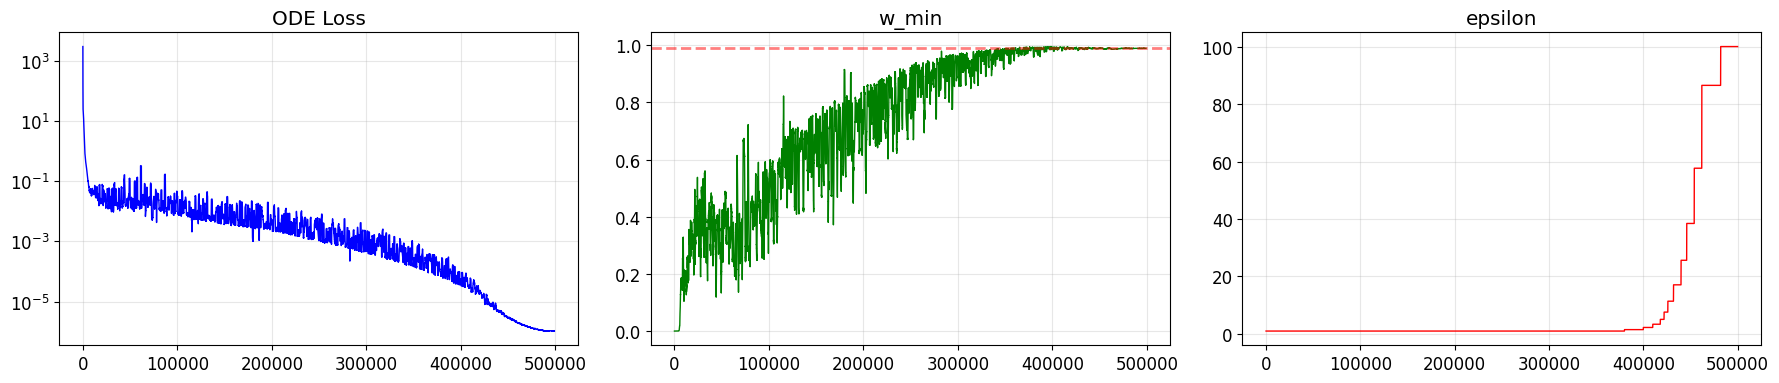

In [19]:
# Training Diagnostics
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
ns = min(1000, len(lo_hist)//10)
if ns > 1:
    axes[0].semilogy(np.convolve(lo_hist, np.ones(ns)/ns, 'valid'), 'b-', lw=1)
axes[0].set_title('ODE Loss'); axes[0].grid(alpha=0.3)
if ns > 1:
    axes[1].plot(np.convolve(wmin_hist, np.ones(ns)/ns, 'valid'), 'g-', lw=1)
axes[1].axhline(0.99, color='r', ls='--', alpha=0.5); axes[1].set_title('w_min'); axes[1].grid(alpha=0.3)
axes[2].plot(eps_hist, 'r-', lw=1); axes[2].set_title('epsilon'); axes[2].grid(alpha=0.3)
plt.tight_layout(); plt.savefig('diag_pd.png', dpi=150, bbox_inches='tight'); plt.show()

In [20]:
# ═══════════════════════════════════════════════════════════
# Evaluation Functions
# ═══════════════════════════════════════════════════════════
def solve_ode(x0, f_np, T, u_func=None, npts=2000):
    rhs = (lambda t,x: f_np(x, u_func(t))) if u_func else (lambda t,x: f_np(x, 0.0))
    sol = solve_ivp(rhs, [0,T], x0, method='RK45', t_eval=np.linspace(0,T,npts),
                    rtol=1e-10, atol=1e-12)
    return sol.t, sol.y.T

def wrap_angle(x, idx=0):
    x = x.copy(); x[idx] = (x[idx]+np.pi)%(2*np.pi)-np.pi
    return x

@torch.no_grad()
def predict_recursive(model, x0, u_func, Tw, Tt, ns, ppw=50, wrap_idx=None):
    model.eval()
    nw = int(np.ceil(Tt/Tw)); tau = np.linspace(0, Tw, ns)
    all_t, all_x = [0.0], [np.array(x0)]
    xc = np.array(x0, dtype=np.float32)
    for w in range(nw):
        ts=w*Tw; te=min((w+1)*Tw, Tt); dt=te-ts
        if dt<1e-10: break
        if u_func is not None:
            us = np.array([u_func(ts+t) for t in tau], dtype=np.float32)
            ust = torch.tensor(us, device=device).unsqueeze(0)
        else:
            ust = torch.zeros(1, ns, device=device)
        x0t = torch.tensor(xc, device=device).unsqueeze(0)
        npts = max(int(ppw*dt/Tw), 2)
        tq = torch.tensor(np.linspace(0,dt,npts)[1:], dtype=torch.float32, device=device).unsqueeze(1)
        xp = model(x0t.expand(len(tq),-1), ust.expand(len(tq),-1), tq).cpu().numpy()
        for k in range(len(tq)):
            all_t.append(ts+tq[k].item()); all_x.append(xp[k])
        xc = xp[-1]
        if wrap_idx is not None:
            xc = wrap_angle(xc, wrap_idx)
    return np.array(all_t), np.array(all_x)

@torch.no_grad()
def predict_feedback(model, x0, fb_fn, Tw, Tt, ns, h_fb=None, wrap_idx=None):
    """Recursive with state-dependent feedback u(x)."""
    model.eval()
    step = h_fb if h_fb else Tw
    nw = int(np.ceil(Tt/step))
    all_t, all_x = [0.0], [np.array(x0)]
    xc = np.array(x0, dtype=np.float32)
    tau = np.linspace(0, Tw, ns)
    for w in range(nw):
        t_now = w*step
        if t_now >= Tt-1e-10: break
        dt = min(step, Tt-t_now)
        uv = np.clip(fb_fn(xc), -2, 2)
        us = np.full(ns, uv, dtype=np.float32)
        ust = torch.tensor(us, device=device).unsqueeze(0)
        x0t = torch.tensor(xc, device=device).unsqueeze(0)
        tq = torch.tensor([dt], dtype=torch.float32, device=device).unsqueeze(1)
        xn = model(x0t, ust, tq).cpu().numpy()[0]
        all_t.append(t_now+dt); all_x.append(xn)
        xc = xn
        if wrap_idx is not None: xc = wrap_angle(xc, wrap_idx)
    return np.array(all_t), np.array(all_x)

def l2_rel(pred, true):
    return [np.sqrt(np.mean((pred[:,i]-true[:,i])**2))/max(np.sqrt(np.mean(true[:,i]**2)),1e-10)*100
            for i in range(pred.shape[1])]

def match_grids(tp, xp, tt):
    return interp1d(tp, xp, axis=0, kind='linear', fill_value='extrapolate')(tt)

print('Evaluation functions ready')

Evaluation functions ready



Figure 6: Stable response, feedback u=-0.8*theta_dot


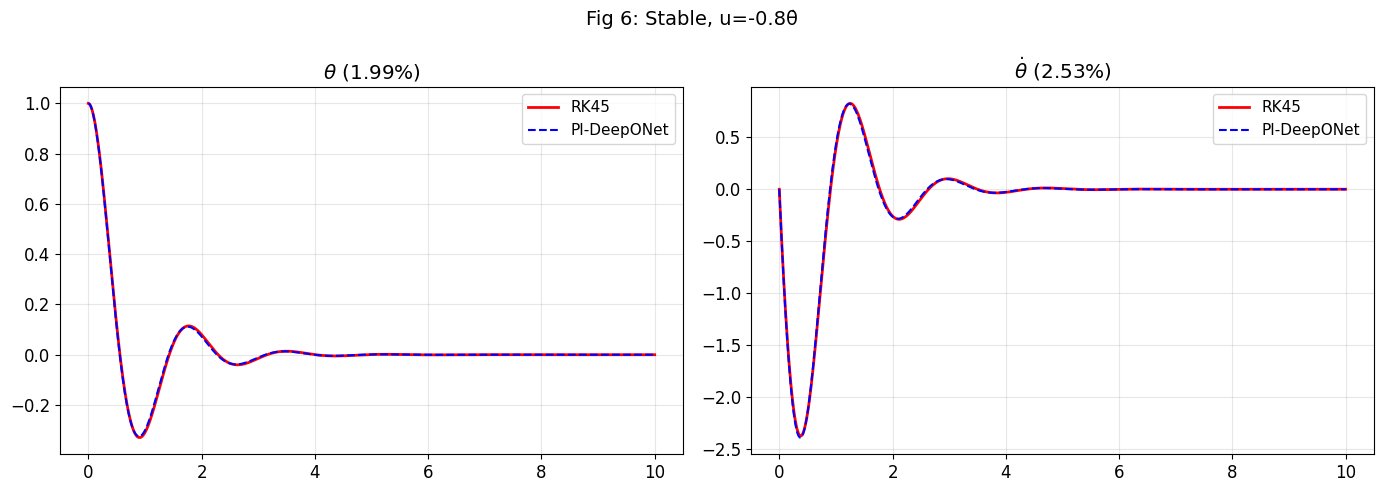

  Feedback: θ=1.986%, θ̇=2.531%


In [21]:
# ═══════════════════════════════════════════════════════════
# Paper Figure 6: Stable response u1(t)=-0.8*theta_dot (feedback)
# ═══════════════════════════════════════════════════════════
print('\n' + '='*60)
print('Figure 6: Stable response, feedback u=-0.8*theta_dot')
print('='*60)

pd_fb = lambda x: -0.8 * x[1]
pd_x0_s = [1.0, 0.0]

t_tr, x_tr = solve_ode(pd_x0_s, pd_f_np, PD_TT,
                        lambda t: -0.8*0.0, 2000)  # need proper feedback solve
# Proper feedback ODE
sol_fb = solve_ivp(lambda t,x: pd_f_np(x, -0.8*x[1]),
                   [0, PD_TT], pd_x0_s, method='RK45',
                   t_eval=np.linspace(0, PD_TT, 2000), rtol=1e-10, atol=1e-12)
t_tr_fb, x_tr_fb = sol_fb.t, sol_fb.y.T

t_pr_fb, x_pr_fb = predict_feedback(pd_model, pd_x0_s, pd_fb,
                                     PD_TW, PD_TT, N_SENSORS, h_fb=PD_TW, wrap_idx=0)
x_pi_fb = match_grids(t_pr_fb, x_pr_fb, t_tr_fb)
e_fb = l2_rel(x_pi_fb, x_tr_fb)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, lb in enumerate([r'$\theta$', r'$\dot{\theta}$']):
    axes[i].plot(t_tr_fb, x_tr_fb[:,i], 'r-', lw=2, label='RK45')
    axes[i].plot(t_pr_fb, x_pr_fb[:,i], 'b--', lw=1.5, label='PI-DeepONet')
    axes[i].set_title(f'{lb} ({e_fb[i]:.2f}%)'); axes[i].legend(); axes[i].grid(alpha=0.3)
plt.suptitle('Fig 6: Stable, u=-0.8θ̇', fontsize=14)
plt.tight_layout(); plt.savefig('fig6_pd.png', dpi=150, bbox_inches='tight'); plt.show()
print(f'  Feedback: θ={e_fb[0]:.3f}%, θ̇={e_fb[1]:.3f}%')


Figure 7: Oscillatory, u=sin(t/2)


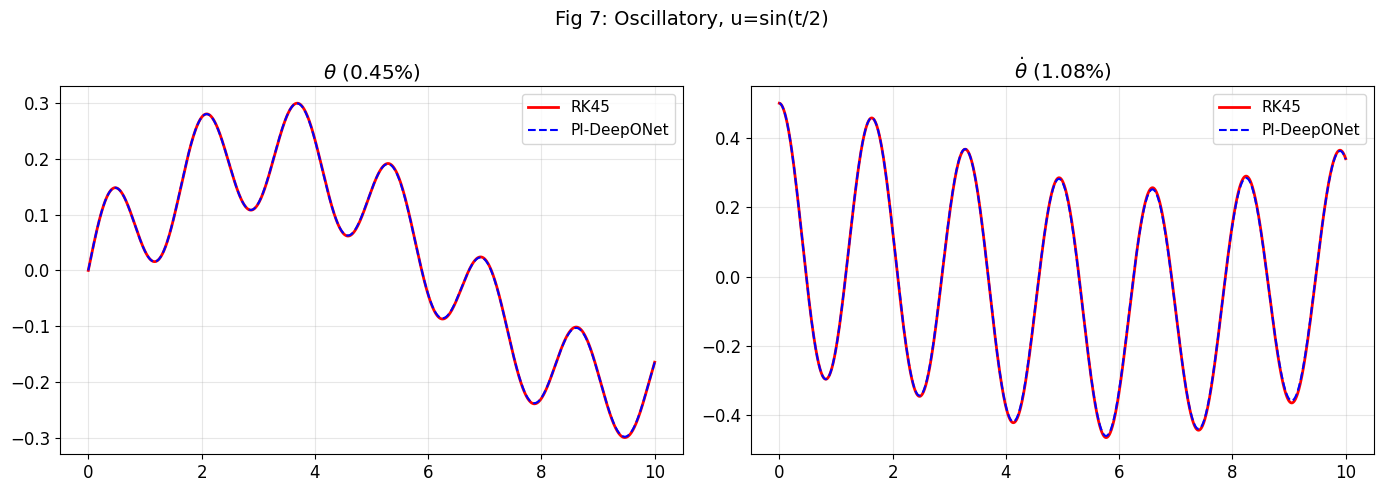

  T<= 1s: θ=0.114%  θ̇=0.111%
  T<= 2s: θ=0.119%  θ̇=0.158%
  T<= 5s: θ=0.299%  θ̇=0.703%
  T<=10s: θ=0.451%  θ̇=1.085%


In [22]:
# ═══════════════════════════════════════════════════════════
# Paper Figure 7: Oscillatory u2(t)=sin(t/2)
# ═══════════════════════════════════════════════════════════
print('\n' + '='*60)
print('Figure 7: Oscillatory, u=sin(t/2)')
print('='*60)

pd_u_osc = lambda t: np.sin(t/2)
pd_x0_osc = [0.0, 0.5]
t_tr_o, x_tr_o = solve_ode(pd_x0_osc, pd_f_np, PD_TT, pd_u_osc, 2000)
t_pr_o, x_pr_o = predict_recursive(pd_model, pd_x0_osc, pd_u_osc,
                                    PD_TW, PD_TT, N_SENSORS, wrap_idx=0)
x_pi_o = match_grids(t_pr_o, x_pr_o, t_tr_o)
e_osc = l2_rel(x_pi_o, x_tr_o)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for i, lb in enumerate([r'$\theta$', r'$\dot{\theta}$']):
    axes[i].plot(t_tr_o, x_tr_o[:,i], 'r-', lw=2, label='RK45')
    axes[i].plot(t_pr_o, x_pr_o[:,i], 'b--', lw=1.5, label='PI-DeepONet')
    axes[i].set_title(f'{lb} ({e_osc[i]:.2f}%)'); axes[i].legend(); axes[i].grid(alpha=0.3)
plt.suptitle('Fig 7: Oscillatory, u=sin(t/2)', fontsize=14)
plt.tight_layout(); plt.savefig('fig7_pd.png', dpi=150, bbox_inches='tight'); plt.show()

for Th in [1, 2, 5, 10]:
    mask = t_tr_o <= Th
    if mask.sum() < 2: continue
    eh = l2_rel(x_pi_o[mask], x_tr_o[mask])
    print(f'  T<={Th:2d}s: θ={eh[0]:.3f}%  θ̇={eh[1]:.3f}%')

In [23]:
# ═══════════════════════════════════════════════════════════
# Paper Table 2 (CORRECT conditions): 100 ICs, u(t)=sin(t/2)
# Paper: θ₀ ∈ [-π/2, π/2], θ̇₀ = 0, u(t) = sin(t/2), T=10s
# ═══════════════════════════════════════════════════════════
print('\n' + '='*60)
print('Paper Table 2 (CORRECT conditions)')
print('  θ₀ ∈ [-π/2, π/2], θ̇₀ = 0, u(t) = sin(t/2), T=10s')
print('='*60)

pd_u_paper = lambda t: np.sin(t/2)
rng_paper = np.random.RandomState(42)
errs_paper_th, errs_paper_om = [], []

for ii in range(100):
    th0 = rng_paper.uniform(-np.pi/2, np.pi/2)
    x0i = [th0, 0.0]  # theta_dot = 0 as per paper
    try:
        t_tr, x_tr = solve_ode(x0i, pd_f_np, PD_TT, pd_u_paper, 2000)
        t_pr, x_pr = predict_recursive(pd_model, x0i, pd_u_paper,
                                        PD_TW, PD_TT, N_SENSORS, wrap_idx=0)
        x_tr_w = x_tr.copy(); x_tr_w[:,0] = (x_tr_w[:,0]+np.pi)%(2*np.pi)-np.pi
        x_pr_w = x_pr.copy(); x_pr_w[:,0] = (x_pr_w[:,0]+np.pi)%(2*np.pi)-np.pi
        xp = match_grids(t_pr, x_pr_w, t_tr)
        e = l2_rel(xp, x_tr_w)
        errs_paper_th.append(e[0]); errs_paper_om.append(e[1])
    except:
        continue
    if (ii+1) % 25 == 0: print(f'  {ii+1}/100 done', flush=True)

errs_paper_th = np.array(errs_paper_th)
errs_paper_om = np.array(errs_paper_om)

print(f'\n{"":>15s} {"θ":>10s} {"θ̇":>10s}')
print('-'*38)
print(f'{"Mean":>15s} {errs_paper_th.mean():10.3f}% {errs_paper_om.mean():10.3f}%')
print(f'{"Std":>15s} {errs_paper_th.std():10.3f}% {errs_paper_om.std():10.3f}%')
print(f'{"Median":>15s} {np.median(errs_paper_th):10.3f}% {np.median(errs_paper_om):10.3f}%')
print(f'{"Max":>15s} {errs_paper_th.max():10.3f}% {errs_paper_om.max():10.3f}%')
good5  = [(errs_paper_th<5).sum(), (errs_paper_om<5).sum()]
good1  = [(errs_paper_th<1).sum(), (errs_paper_om<1).sum()]
print(f'{"Cases<1%":>15s} {good1[0]:>7d}/100 {good1[1]:>7d}/100')
print(f'{"Cases<5%":>15s} {good5[0]:>7d}/100 {good5[1]:>7d}/100')
print('-'*38)
print(f'Paper DeepONet (10k data):  θ=0.83%  θ̇=1.06%')
print(f'Ours (ZERO data):           θ={errs_paper_th.mean():.3f}%  θ̇={errs_paper_om.mean():.3f}%')

# Multi-horizon breakdown
print('\nMulti-horizon (worst-case IC = θ₀=π/2):')
x0_worst = [np.pi/2, 0.0]
t_tr, x_tr = solve_ode(x0_worst, pd_f_np, PD_TT, pd_u_paper, 2000)
t_pr, x_pr = predict_recursive(pd_model, x0_worst, pd_u_paper,
                                PD_TW, PD_TT, N_SENSORS, wrap_idx=0)
xp = match_grids(t_pr, x_pr, t_tr)
for Th in [1, 2, 5, 10]:
    mask = t_tr <= Th
    if mask.sum() < 2: continue
    eh = l2_rel(xp[mask], x_tr[mask])
    print(f'  T<={Th:2d}s: θ={eh[0]:.3f}%  θ̇={eh[1]:.3f}%')


Paper Table 2 (CORRECT conditions)
  θ₀ ∈ [-π/2, π/2], θ̇₀ = 0, u(t) = sin(t/2), T=10s
  25/100 done
  50/100 done
  75/100 done
  100/100 done

                         θ         θ̇
--------------------------------------
           Mean      0.506%      0.621%
            Std      0.286%      0.387%
         Median      0.375%      0.447%
            Max      1.164%      1.998%
       Cases<1%      89/100      81/100
       Cases<5%     100/100     100/100
--------------------------------------
Paper DeepONet (10k data):  θ=0.83%  θ̇=1.06%
Ours (ZERO data):           θ=0.506%  θ̇=0.621%

Multi-horizon (worst-case IC = θ₀=π/2):
  T<= 1s: θ=0.015%  θ̇=0.002%
  T<= 2s: θ=0.039%  θ̇=0.037%
  T<= 5s: θ=0.360%  θ̇=0.425%
  T<=10s: θ=1.122%  θ̇=1.133%


In [25]:
# ═══════════════════════════════════════════════════════════
# BONUS: Stress test — random u(t), extreme ICs (NOT paper conditions)
# θ₀∈[-π,π], θ̇₀∈[-8,8], u=Asin(ωt+φ) random — MUCH harder than paper
# ═══════════════════════════════════════════════════════════
print('\n' + '='*60)
print('Statistical Test: 100 ICs, open-loop, T=10s')
print('='*60)

rng_ol = np.random.RandomState(777)
errs_th, errs_om = [], []
for ii in range(100):
    x0i = [rng_ol.uniform(-np.pi, np.pi), rng_ol.uniform(-8, 8)]
    A = rng_ol.uniform(0.3, 2.0); w = rng_ol.uniform(0.5, 4.0)
    ph = rng_ol.uniform(0, 2*np.pi)
    uf = lambda t, A=A, w=w, ph=ph: np.clip(A*np.sin(w*t+ph), -2, 2)
    try:
        t_tr, x_tr = solve_ode(x0i, pd_f_np, PD_TT, uf, 2000)
        t_pr, x_pr = predict_recursive(pd_model, x0i, uf, PD_TW, PD_TT,
                                        N_SENSORS, wrap_idx=0)
        x_tr_w = x_tr.copy(); x_tr_w[:,0] = (x_tr_w[:,0]+np.pi)%(2*np.pi)-np.pi
        x_pr_w = x_pr.copy(); x_pr_w[:,0] = (x_pr_w[:,0]+np.pi)%(2*np.pi)-np.pi
        xp = match_grids(t_pr, x_pr_w, t_tr)
        e = l2_rel(xp, x_tr_w)
        errs_th.append(e[0]); errs_om.append(e[1])
    except:
        continue
    if (ii+1) % 25 == 0: print(f'  {ii+1}/100 done', flush=True)

errs_th, errs_om = np.array(errs_th), np.array(errs_om)
print(f'\n{"":>15s} {"θ":>10s} {"θ̇":>10s}')
print('-'*38)
print(f'{"Mean":>15s} {errs_th.mean():10.3f}% {errs_om.mean():10.3f}%')
print(f'{"Std":>15s} {errs_th.std():10.3f}% {errs_om.std():10.3f}%')
print(f'{"Median":>15s} {np.median(errs_th):10.3f}% {np.median(errs_om):10.3f}%')
good_th = (errs_th<5).sum(); good_om = (errs_om<5).sum()
print(f'{"Cases<5%":>15s} {good_th:>7d}/100 {good_om:>7d}/100')
good10_th = (errs_th<10).sum(); good10_om = (errs_om<10).sum()
print(f'{"Cases<10%":>15s} {good10_th:>7d}/100 {good10_om:>7d}/100')
print('-'*38)


Statistical Test: 100 ICs, open-loop, T=10s
  25/100 done
  50/100 done
  75/100 done
  100/100 done

                         θ         θ̇
--------------------------------------
           Mean     52.286%     27.490%
            Std     51.811%     35.435%
         Median     34.530%     11.951%
       Cases<5%      36/100      43/100
      Cases<10%      39/100      46/100
--------------------------------------
